# Implementing and testing the Pr0 function for Hahn Echo measurements

A. Gentile

07/2017

In [1]:
import qinfer as qi
import numpy as np
import scipy as sp
import qutip as qt
import sys, os

In [2]:
import matplotlib.pyplot as plt

### Plotting of expected decay from the NV centre Hahn echo measurement

Just a quick plot of the expected T2 decay general behaviour

In [201]:
tvec = (np.array(range(70)))
T2 = 65
pr0es = np.expm1(-(tvec/T2)**3)+1

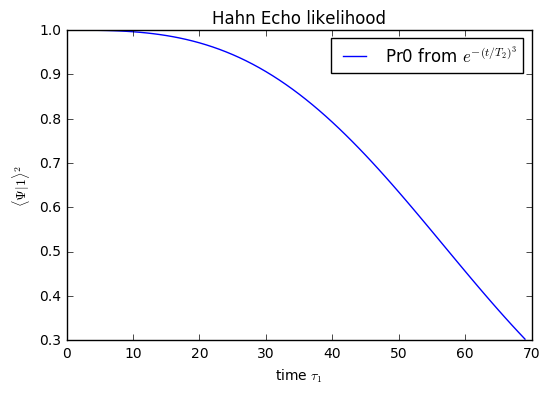

In [202]:
plt.plot(tvec,pr0es, label='Pr0 from $e^{-(t/T_2)^3}$')
#plt.scatter(tvec, datum[0][0], label='sim. exp.')
plt.legend()
plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1$')
plt.ylabel(r'$\langle \Psi | 1 \rangle ^2 $')

plt.show()

### Trying to fit Hahn-Echo experimental data

Import experimental data ad libitum

In [32]:
filename = os.path.join("..","..","..","Hamiltonian Learning With Seb","Test_data_Hahn","Test_data_Hahn","overall_data.csv")
Hahn_data = np.loadtxt(open(os.path.abspath(filename), "rb"), delimiter=",", skiprows=1)

In [33]:
Hahn_data.shape # chech the correct dims

(277, 2)

Select a range of data to plot (makes the oscillatory behaviour more clear 
when datasets are intervalled by huge "gaps").
I have selected the first three oscillations as there are no "gaps" in between them as data collection, which makes it a bit easier to infer a possible fit

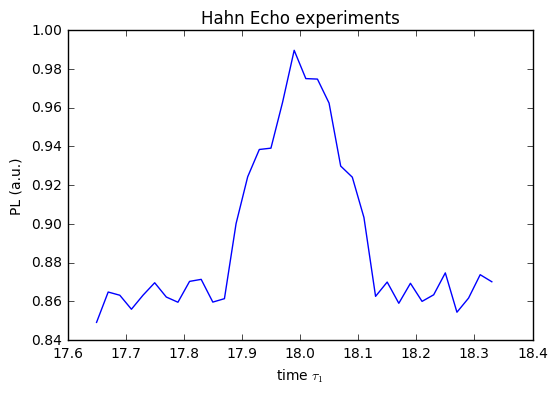

In [49]:
myrange = range(140, min(Hahn_data.shape[0],175)) 
xdata = Hahn_data[myrange,0]/1000 # converted to us
ydata = Hahn_data[myrange,1]

plt.plot(xdata, ydata)
plt.title('Hahn Echo experiments')
plt.xlabel(r'time $\tau_1$')
plt.ylabel('PL (a.u.)')

plt.show()

In [207]:
from scipy import optimize

def sinfit(x, a, b, c, d):
    return a*(np.sin(b*x + c)) + d

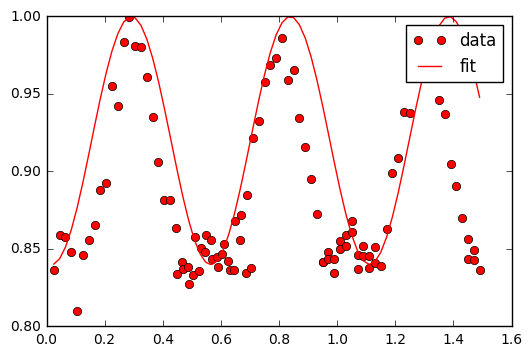

In [224]:
# Initial guess for the parameters
manpopt = np.array([0.08, 1.15*10**(1), 4.5, 0.92]) 
plt.plot(xdata, ydata, "ro", xdata, sinfit(xdata, *manpopt), 'r-')
plt.legend(('data', 'fit'))
plt.show()

Fitting parameters: [  0.08062236  12.68580406   2.40402812   0.90695399]


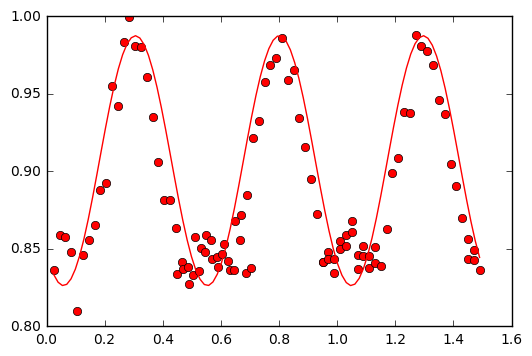

In [225]:
# Fit the data set
fitfunc = lambda p, x: p[0]*(np.cos(p[1]*x+p[2])) + p[3] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

# Least square optimization
p1, success = optimize.leastsq(errfunc, manpopt, args=(xdata, ydata))
p1[0] = p1[0] + 0.015
p1[3] = p1[3] + 0.015
print("Fitting parameters: " + str(p1)) # fitting parameters

time = np.linspace(xdata.min(), xdata.max(), 100)
plt.plot(xdata, ydata, "ro", time, fitfunc(p1, time), "r-") # Plot of the data and the fit

plt.show()

The fitting to a sinusoid does not look particularly bad to me. Yet very noisy, this is true.

Nevertheless, if we "just" introduce $H_f$ as the Hamiltonian governing the system dynamics, we can only expect oscillatory behaviours... I could not find a better "fitting" of Hahn echo experiments, if any more specific clue, please let me know? 

# Preliminary observation of the 2-qubit dynamic

In [3]:
# Add personalized library to PYTHONPATH
import sys, os
sys.path.append(os.path.join("..","Libraries","QML_lib"))

In [4]:
from Norms import *
from IOfuncts import *
from EvalLoss import *

import ProbeStates as pros
import multiPGH as mpgh
import GenSimQMD as gsi
import Evo as evo
import Distrib as distr

In [5]:
import importlib as imp

imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)

<module 'Distrib' from '..\\Libraries\\QML_lib\\Distrib.py'>

In [6]:
spinlst = [evo.sigmax(), evo.sigmay(), evo.sigmaz()]    

In [8]:
# Implement the NV centre spin- nuclear (iso)spin interaction term

oplist = np.array(list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))

# oplist = np.array(list(map(lambda j: np.kron(np.eye(2),spinlst[j]) + np.kron(spinlst[j],np.eye(2)) + np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))
# print('Oplist: ' + repr(oplist))

Including the usual "identity" terms in Hp, we introduce unwanted beatings

In [9]:
# Implement a phase damping channel UNITARY (do NOT exp!)
def deco1q(t, Gamma):
    return np.array([[np.sqrt(1- Gamma*t),np.sqrt(Gamma*t),0,0],
                   [np.sqrt(Gamma*t),np.sqrt(1- Gamma*t),0,0],
                   [0,0,np.sqrt(1- Gamma*t),np.sqrt(Gamma*t)],
                   [0,0,np.sqrt(Gamma*t),np.sqrt(1- Gamma*t)]])

t = 0.1
Gamma = 0.02
print(deco1q(t, Gamma))
print("Is Unitary? " + str(np.all(deco1q(t, Gamma).conj().T==deco1q(t, Gamma))))

[[ 0.9989995   0.04472136  0.          0.        ]
 [ 0.04472136  0.9989995   0.          0.        ]
 [ 0.          0.          0.9989995   0.04472136]
 [ 0.          0.          0.04472136  0.9989995 ]]
Is Unitary? True


In [10]:
probestate = np.kron(evo.plus(), pros.def_randomprobe(evo.sigmax()))
probestate

array([ 0.29334325+0.04944508j,  0.43474375+0.47170201j,
        0.29334325+0.04944508j,  0.43474375+0.47170201j])

In [11]:
probestate=np.dot(deco1q(t, Gamma),probestate)

checking that Hproj actually projects back to $|0\rangle$ [evo.zero]

In [12]:
Hproj = np.kron(np.pi/4*spinlst[1],np.eye(2))

In [13]:
evostate = np.dot(sp.linalg.expm(-(1j)*1*Hproj), probestate)
qt_evostate = qt.Qobj(evostate)
qt_evostate.dims = [[2,2],[1,1]]
qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.zero()) )

0.0

In [14]:
qt_probestate = qt.Qobj(probestate)
qt_probestate.dims = [[2,2],[1,1]]
qt_probestate

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.3124921+0.07049076j]
 [ 0.4474275+0.47344133j]
 [ 0.3124921+0.07049076j]
 [ 0.4474275+0.47344133j]]

In [15]:
qt_probestate.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.52695831  0.52695831]
 [ 0.52695831  0.52695831]]

In [16]:
qt.expect(qt_probestate.ptrace(0), qt.Qobj(evo.plus()) )

1.0539166295561193

### tracing out the nuclear degree of freedom

True params are chosen according to Felton et al. PHYSICAL REVIEW B 79, 075203 2009
Values in $MHz$ give rise to $\mu s$ time scales 

In [24]:
# np.array([[0.27, 0.27, 0.214]])
# np.array([[0., 0., 0.007]])

true_params = np.array([[0., 0., 2]])
print('Chosen true_params: ' + str(true_params))

Chosen true_params: [[ 0.  0.  2.]]


In [25]:
Hp = evo.getH(true_params[0, np.newaxis], oplist)
#Hp = Hp + np.kron(np.eye(2),5.5*spinlst[0])  # this term decreases the visibility of the fringes and influences the frequency of the beatings
#Hp = Hp + np.kron(1*spinlst[1], np.eye(2))
print('Hp: ' + repr(Hp))

Hp: array([[ 2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  2.+0.j]])


In [26]:
Hahn_angle = np.pi/2

Hm = np.kron(Hahn_angle*spinlst[2],np.eye(2))
#Hm = np.kron(np.pi/2*spinlst[2],np.eye(2)+2*spinlst[0])
Hm

array([[ 1.57079633,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.57079633,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.57079633, -0.        ],
       [ 0.        ,  0.        , -0.        , -1.57079633]])

In [27]:
probestate = np.kron(evo.plus(), pros.def_randomprobe(evo.sigmax()))
#probestate = np.kron(evo.plus(), evo.plus())

qt_probestate = qt.Qobj(probestate)
qt_probestate.dims = [[2,2],[1,1]]
qt_probestate.ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.54719257+0.j          0.39699459+0.30028013j]
 [ 0.39699459-0.30028013j  0.45280743+0.j        ]]

In [30]:
tvec = np.linspace(0.,8.8,400)
evolve = np.empty(len(tvec))
T2 = 5
offset = 0.
Gamma = 0.


for idt in range(len(tvec)):
    
    ## Mechanisms to simulate decoherence via the 2-qubit model
    ## 1: random fluctuations in the initial choice of the probe - cancelled by Hann echo
    #probestate = np.kron(evo.plus(), pros.def_randomprobe(evo.sigmax())) 
    
    evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Hp), probestate)
    
    evostate = np.dot(sp.linalg.expm(-(1j)*1*Hm), evostate)    # Hahn-echo operation
    
    ## 2: residual random fluctuations in the nuclear spin after the Hahn echo
    Hdec = np.kron(np.eye(2),spinlst[0]*tvec[idt]/T2)
    Htot = Hp + Hdec
    
    evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)
    
    
    #evostate = np.dot(deco1q(tvec[idt], Gamma), evostate)
    
    

    
    #evostate = np.dot(sp.linalg.expm(-(1j)*1*Hproj), evostate) # "projection" back to |0>
    
    qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
    qt_evostate.dims = [[2,2],[1,1]]
    
    ## Partial tracing over the nuclear deg of freedom
    evolve[idt] = qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.minus()) )
    #evolve[idt] = qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) )
    
    ## Mechanisms to simulate decoherence imposing the external fit
    #deco = np.expm1(-(tvec[idt]/T2)**3)+1
    deco = 1
    
    evolve[idt] = offset+deco*(evolve[idt]*(1-offset))

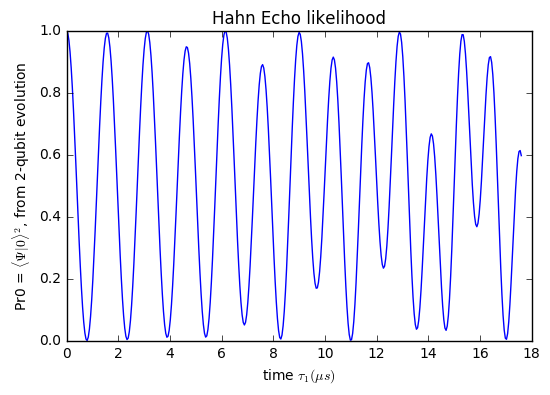

In [31]:
plt.plot(2*tvec, evolve)

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

$\textit{evolution only under Hp (Hahn echo operation not effectively included)}$
- the evolution is strongly dependent on the choice of the initial (random) nuclei probestate. It is affected only by $\sigma_z \otimes \sigma_z$ and $\sigma_y \otimes \sigma_y$, therefore $A_{//,x}$ has no effect on the evolution. 
- Ignore this possibility, as it would be difficult to justify control/readout of the nuclei spin at the beginning/end of the evolution?

$\textit{evolution under Hp full Hahn echo}$

with Hm = np.kron(np.pi/2*spinlst[2],np.eye(2)) we assume the nuclear spin is static throughout the whole evolution

- evolution independent of the initial choice of the nuclear probe state (ideally because of the $\pi$ flip on the equator, which should be good to us)
- $A_{//,z}$ is of order 6 MHz to reproduce experimental periodicity of Seb's thesis (** never mind, I had adopted $\mu s$ instead of $ns$ in your data!!! Unfortunately though, I do have a degeneracy in the sign, so I cannot estimate whether it is + VS -**). However this seems now far from the 0.214 MHz value for Sangtawesin thesis.

- it is also well protected from "noise" introduced by altering the choice of the initial state at the beginning of each step in the evolution, unless errors in the Hahn angle rotation are introduced
- as such, there is no way to reduce the "visibility" of the oscillations in $\langle \Psi | 0 \rangle ^2 $ by clever choices of the probe state at the beginning
- evolution depends only on the $\sigma_z \otimes \sigma_z$ term of the $H_f$ interaction, so it is effectively a 1-parameter estimate. $A_{//,x}$ has no effect on the evolution as the system is prepared in $|+\rangle$ (well, ideally), whereas $A_{//,y}$ is ruled out by the $\pi$ flip **therefore correct, $A_{\perp,z}$ in this configuration is the dominant effect in the oscillatory behaviour generated by $H_f$**


- I call (improperly I guess, just to make things easier) hereafter "visibility" the amplitude of the oscillations in the PL observed in the data

- **if it was not for the Hahn echo, we could have beatings in the oscillations (that would not be screened from $A_{//,x}$ and $A_{//,y}$, and these beatings could explain different frequencies and the reduced visibility at the beginning of the evolution. However, because of the Hahn echo procedure this seems not the case, unless the partial trace is doing something weird** 
- however, we can introduce an error in the $\pi$ rotation to both simulate decoherence and visibility effects. This is not very useful to me, because: i) it must be a huge one to match experimental data (around $\sim 0.2$ rad); ii) I do not see why this error should increase with time
- more interestingly, $\textit{visibility}$ can be reduced by introducing $\sigma_x$ or $\sigma_y$ terms in the nuclear Hamiltonian (i.e. they effectively undergo a precession). It can also adjust the frequency of the fringes.
- if the trick as above is deemed unacceptable, then the $\textit{offset}$ must be introduced artificially to decrease visibility... is that OK? 

Question 1: do we NOT expect full visibility at all (but full visibility naturally arises from the coupling to the additional spin, I see no other physical reason to reduce the expectetion value of $| \langle 0 | \Psi_{evo} \rangle |^2$?

- as for the $\textit{decoherence}$, the most trivial way is to impose it as an external parameter $T_2$ straight in the final expectation value. However this brings no advantage to multi qubit model (it can be well implemented also in the 1 qubit one). 
- choosing the probestate at the beginning of the evolution, altering the ratio of the two Hahn echo sequences has no effect. Also, I do not see as above why this ratio should be more prone to errors for longer evolution times.
- I have modified the code to include a $\textit{depolarising channel}$ as a unitary mapping (to be specific a **phase damping** as from Preskill notes). This ideally involves a 4-dim environment space for a single qubit, i.e. too big for our system. I was trying to capture the effect with a smaller 2dim space, and I hope this would make referees not too annoyed by discrepancies between ideal case and experimentally accomplished case. However, the Hamiltonian would NOT be anymore just the hyperfine interaction. **Something weird seeems happening with the partial tracing as implemented in Python, I need to do some debugging to solve this.**


Question 2: do we want to use decoherence as well to make less likely to succeed the 1-qubit models? I think the idea is a nice selling point, but at the expense of learning the hyperfine Hamiltonian. Or they would be two different competitive models. Also, is it ok to analyse just partially a depolarising channel? We can hope that simulations favour the 2-qubits but this is not granted.

### standard evolution assuming global state known

In [368]:
tvec = np.linspace(0.,35,100)

evolve = np.empty(len(tvec))
for idt in range(len(tvec)):
    Hp = evo.getH(true_params[0, np.newaxis], oplist)
    #probestate = np.kron(evo.plus(), pros.def_randomprobe(evo.sigmax()))
    evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Hp), probestate)
    evostate = np.dot(deco1q(tvec[idt], Gamma), evostate)
    evolve[idt] = np.abs(np.dot(evostate.conj(), probestate.T)) ** 2

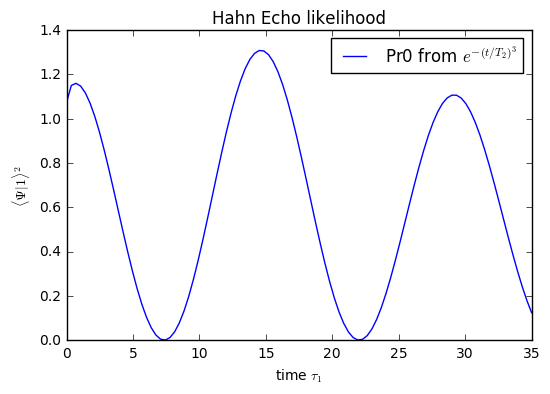

In [369]:
plt.plot(tvec,evolve, label='Pr0 from $e^{-(t/T_2)^3}$')
#plt.scatter(tvec, datum[0][0], label='sim. exp.')
plt.legend()
plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1$')
plt.ylabel(r'$\langle \Psi | 1 \rangle ^2 $')

plt.show()